# Simulations with large ptychographic scan steps (ie sparse scans) and with low values for the scattering amplitudes (ie weak).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation, Simulation
from skimage.feature import register_translation
from skimage.restoration import unwrap_phase
from scipy import io
import copy
import os
import dill
import ast
import h5py

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
base_path = os.environ['HOME']

In [4]:
base_path

'/home/skandel'

In [5]:
probe_2d = io.loadmat(f'{base_path}/code/mbptycho/experiments/matlab/datasets/recon_probe_29902.mat')["prb"]
probes_3d_path = f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/probes_4_peaks.mat'

In [6]:
probes_3d_h5_path = f'{base_path}/code/mbptycho/experiments/matlab/datasets_0821/probes.h5'

NameError: name 'probe_2d_hanning' is not defined

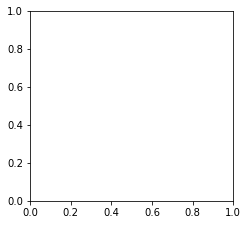

In [7]:
plt.figure(figsize=[8,3.5])
plt.subplot(121)
plt.imshow(np.log10(np.abs(probe_2d_hanning) + 1e-6))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(probe_2d))
plt.colorbar()
plt.show()

In [10]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/apodized_probe_weak_peaks'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

save_plots = False

In [11]:
hkl_list = np.array([[1, 0, 0], [1, 1, 0], [1, 2, 0], [2, 1, 0]])

In [12]:
with open('magnitude_scalings_per_q.txt', 'r') as f:
    scalings = ast.literal_eval(f.read())

FileNotFoundError: [Errno 2] No such file or directory: 'magnitude_scalings_per_q.txt'

In [13]:
scalings

NameError: name 'scalings' is not defined

In [45]:
!rm $sample_data_path

In [46]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm = reloadSimulation(sim_data_path, reload_sim=False,
                      reload_sample_only_filename=sample_data_path,
                      save_sample_only_filename=sample_data_path,
                      new_sim_params={'poisson_noise':True, 
                                      'probes_matlab_h5_file':probes_3d_h5_path, 
                                      'n_scan_positions':1,
                                      'npix_scan_shift':1,
                                      'HKL_list':np.array([[1, 0, 0],
                                                           [1, 1, 0],
                                                           [1, 2, 0],
                                                           [2, 1, 0]]),
                                     'magnitudes_scaling_per_peak': np.array([0.00107052, 0.000707052, 
                                                                              0.0005033028, 0.0003033028]),
                                     'poisson_noise': False},
                      new_extra_sample_params={'strain_type':strain_type, 
                                               'npix_delta_x':5,
                                               'npix_delta_y':5,
                                               'grain_width': 0.5,
                                               'grain_height': 0.45})

Creating new simulation...
Reloading sample from provided file... /home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/apodized_probe_weak_peaks/sample_point_inclusion.pkl
Supplied sample file does not exist.
Creating new sample...
Depth of numerical window covers 0.5844363636363636 microns
Saving sample file.. /home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/apodized_probe_weak_peaks/sample_point_inclusion.pkl
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from h5py file...
Loading successfull...
Saving new simulation at /home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/apodized_probe_weak_peaks/sim_point_inclusion.pkl...


In [48]:
for i in range(4):
    diffs = sm.simulations_per_peak[i].diffraction_patterns
    print(diffs.max(), diffs.sum(axis=(1,2)).max())

42.48241748955556 8249.979567575156
19.15891429002882 2772.3701806402278
16.298208510266857 1323.4368564557892
4.858521514965696 606.5090516871296


IndexError: index 15 is out of bounds for axis 0 with size 1

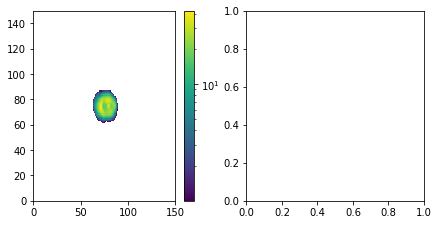

In [49]:
fig = plt.figure(figsize=[7,3.5])
plt.subplot(1,2,1)

data_out = np.fft.fftshift(sm.simulations_per_peak[0].diffraction_patterns[0])
data_out[data_out < 1.] = 0
plt.pcolormesh(data_out,
               norm=mpl.colors.LogNorm())
plt.colorbar()
plt.subplot(1,2,2)

data_out = np.fft.fftshift(sm.simulations_per_peak[0].diffraction_patterns[15])
data_out[data_out < 1.] = 0
plt.pcolormesh(data_out,
               norm=mpl.colors.LogNorm())
plt.colorbar()
plt.show()
print(np.abs(sm.simulations_per_peak[0].diffraction_patterns[0] - 
             sm.simulations_per_peak[0].diffraction_patterns[30]).sum())

print([(sm.simulations_per_peak[i].diffraction_patterns.max(),
        sm.simulations_per_peak[i].diffraction_patterns.sum(axis=(1,2)).max())
       for i in range(3)])
print(sm.simulations_per_peak[0].diffraction_patterns.shape)

In [50]:
ux = sm.sample.Ux_full #/ sm.sample.params.lattice[1]
uy = sm.sample.Uy_full #/ sm.sample.params.lattice[1]
uz = sm.sample.Uz_full #/ sm.sample.params.lattice[1]
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
duz = np.gradient(uz)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy, duz], axis=0)

In [51]:
plots_3d_mask = (~sm.sample.obj_mask_full) #| (~sm.sample.magnitudes_full_mask)

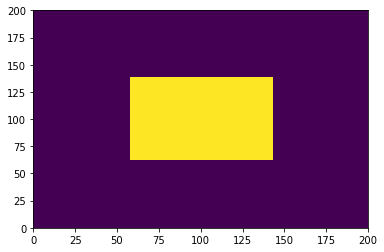

In [52]:
plt.pcolormesh(np.abs(sm.sample.obj_mask_full[...,50]))

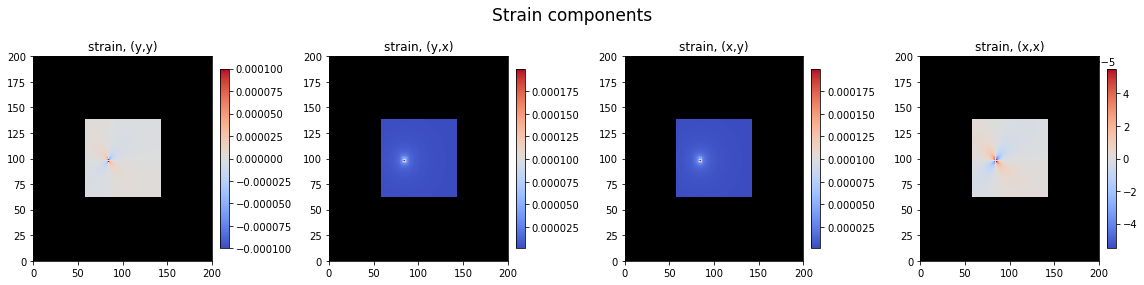

In [53]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j])
        s[i,j][plots_3d_mask] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        if i < 2 and j < 2:
            sl = s[i,j, :, :, 50]
            
        elif i < 2 and j ==2 :
            sl = s[i, j, :,:, 50]
        else:
            sl = s[i, j, :, :, 50]
        
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap)
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

if save_plots:
    plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

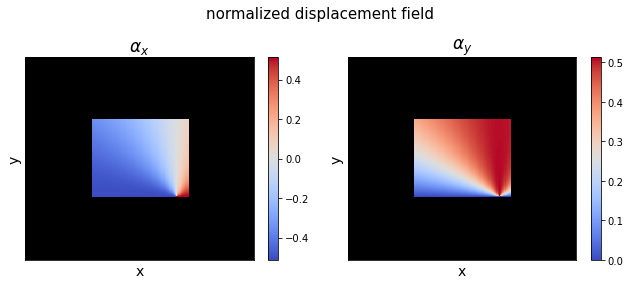

In [39]:
plt.figure(figsize=[9,4])

plt.subplot(1,2,1)
front = sm.sample.Ux_full / sm.sample.params.lattice[1]
front[plots_3d_mask] = np.nan
plt.pcolormesh(front[...,50], cmap=cmap)
plt.colorbar()
#cbar = plt.colorbar(ticks=[-2, -1, 0, 1, 2])
#cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_ylabel(r'$\alpha_y$', fontsize=17) 
plt.xticks([])
plt.yticks([])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r'$\alpha_x$', fontsize=17)

plt.subplot(1,2,2)
front = sm.sample.Uy_full / sm.sample.params.lattice[1]
front[plots_3d_mask] = np.nan
#cmap = mpl.cm.get_cmap('coolwarm')
#cmap.set_bad('black')
plt.pcolormesh(front[...,50], cmap=cmap)
plt.colorbar()
#cbar = plt.colorbar(ticks=[-0.2, -0.1, 0, 0.1, 0.2])
#cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_ylabel(r'$\alpha_y$', fontsize=17) 
plt.xticks([])
plt.yticks([])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r'$\alpha_y$', fontsize=17)
plt.suptitle("normalized displacement field", fontsize=15)
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/displacement.pdf', bbox_inches='tight')
plt.show()

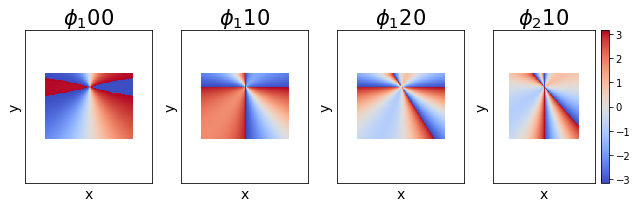

In [27]:
fig, axs = plt.subplots(1, 4, figsize=[9,3])

for i in range(4):
    front = np.angle(sm.sample.rhos[i])
    front[plots_3d_mask] = np.nan
    cax= axs[i].pcolormesh(front[...,50], cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
    peak = ''.join(sm.params.HKL_list[i].astype('str'))
    axs[i].set_xlabel('x', fontsize=14)
    axs[i].set_ylabel('y', fontsize=14)
    axs[i].set_title(fr"$\phi_{peak}$", fontsize=21)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.colorbar(cax, ax=axs[3])
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/phases.pdf', bbox_inches='tight')
plt.show()

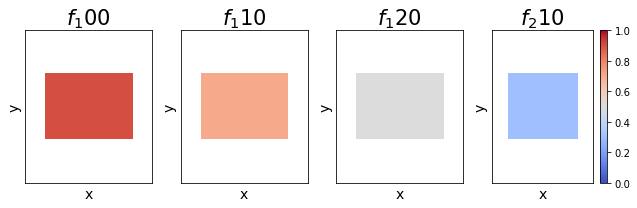

In [71]:
fig, axs = plt.subplots(1, 4, figsize=[9,3])

for i in range(4):
    front = np.abs(sm.rhos[i])
    front[plots_3d_mask] = np.nan
    cax= axs[i].pcolormesh(front[...,51], cmap='coolwarm', vmin=0, vmax=1.0)
    peak = ''.join(sm.params.HKL_list[i].astype('str'))
    axs[i].set_xlabel('x', fontsize=14)
    axs[i].set_ylabel('y', fontsize=14)
    axs[i].set_title(fr"$f_{peak}$", fontsize=21)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.colorbar(cax, ax=axs[3])
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/magnitudes.png', bbox_inches='tight')
plt.show()

NameError: name 'probe_2d_hanning' is not defined

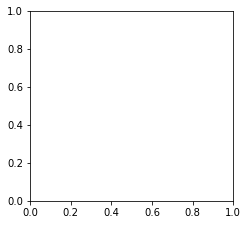

In [72]:
plt.figure(figsize=[8,3.5])
plt.subplot(121)
plt.imshow(np.log10(np.abs(probe_2d_hanning) + 1e-5))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(probe_2d_hanning))
plt.colorbar()
plt.show()

In [30]:

from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

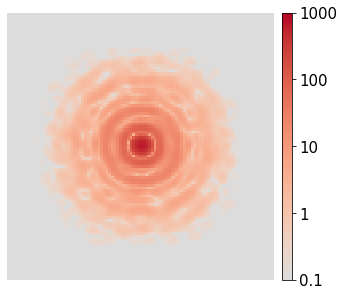

In [31]:
fig, ax = plt.subplots(1,1, figsize=[4, 4], constrained_layout=True)
    

probe_absvals = np.abs(probe_2d_hanning)
probe_angvals = np.angle(probe_2d_hanning)

probe_absvals[probe_absvals<0.1] = 0.1

new_cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.5, maxval=1)

#plt.sca(axes[0,0])
im = ax.pcolormesh(probe_absvals, cmap=new_cmap, norm=LogNorm(vmin=0.1, vmax=1000))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[0.1, 1, 10, 100, 1000])
cb.ax.set_yticklabels([0.1, 1, 10, 100, 1000])
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=15)

ax.set_aspect('equal')
ax.set_axis_off()
#ax.text(0.05, 1.02, '(' + string.ascii_lowercase[i] + ') ' + list(subplot_titles.values())[i],
#            transform=ax.transAxes, size=16)
plt.savefig('probe_mag.pdf', bbox_inches='tight')

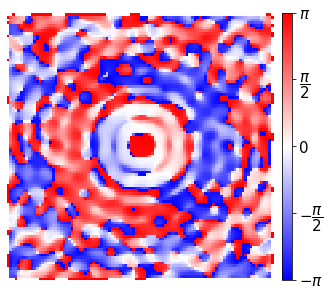

In [32]:
fig, ax = plt.subplots(1,1, figsize=[4, 4], constrained_layout=True)

probe_angvals[probe_absvals<0.1] = 0

im = ax.pcolormesh(probe_angvals, cmap='bwr',vmin=-np.pi, vmax=np.pi)
                          # norm=MidpointNormalize(vmin=-np.pi, vmax=np.pi, midpoint=0))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cb.ax.minorticks_off()
cb.ax.set_yticklabels([r'$-\pi$', r'$-\dfrac{\pi}{2}$', r'0',  r'$\dfrac{\pi}{2}$', r'$\pi$'])
cb.ax.tick_params(labelsize=15)

ax.set_axis_off()
ax.set_aspect('equal')

plt.savefig('probe_phase.pdf', bbox_inches='tight')